# Time Series Analysis

This notebook conducts an analysis on the number of likes, comments, or retweets of toxic tweets over time. We also use and test different ARIMA models to predict the time series.

## Importing the dependencies

We import the necessary dependencies and [utilities](utils.py).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from utils import load_time_series, differenced_series
from configs import DATA_PATHS

## Loading the data

Load a single file for analysis. Choose a path from `DATA_PATHS` imported from [confgis](configs.py) or enter it as a string manually.

In [2]:
DATA_PATHS

['/Users/naman/Workspace/Data/Toxicity-Analysis/Gyanvapiafterdetoxifyandcorrectedlabels.csv',
 '/Users/naman/Workspace/Data/Toxicity-Analysis/indianmusafterdetoxify.csv',
 '/Users/naman/Workspace/Data/Toxicity-Analysis/1coviddetoxify0.5.csv',
 '/Users/naman/Workspace/Data/Toxicity-Analysis/Andhbhaktafterdetoxify.csv',
 '/Users/naman/Workspace/Data/Toxicity-Analysis/GobackModifinallabels1.csv',
 '/Users/naman/Workspace/Data/Toxicity-Analysis/indianmusafterdetoxify-1.csv']

We use the `load_time_series` function from [utilities](utils.py) to load our data. It takes the path to file, column to use as date, and the columns to include as time series as arguments.

In [3]:
data_path = DATA_PATHS[3]
date_column = "created_at"
columns = ["likes", "replies", "retweets", "quote_count"]

data = load_time_series(data_path, date_column, columns)

data.tail()

,likes,replies,retweets,quote_count
created_at,,,,
2022-05-16,182,70,40,1
2022-05-17,227,82,32,7
2022-05-18,707,167,136,17
2022-05-19,88,44,7,1
2022-05-20,174,40,30,2


In [4]:
data.shape

(366, 4)

## Visulaizing the series

Here we plot the series to manually look for patterns in the data. Generally, visualizing the data before doing anything is a good thing. In our case, it is even more important since the ARIMA model takes in a stationary series (series with a constant mean). We can check whether our series are stationary by plotting them.

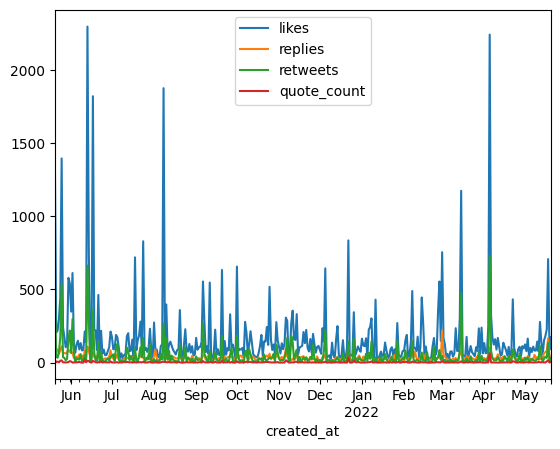

In [5]:
data.plot()
plt.show()

We can also plot each series individually to view it more clearly.

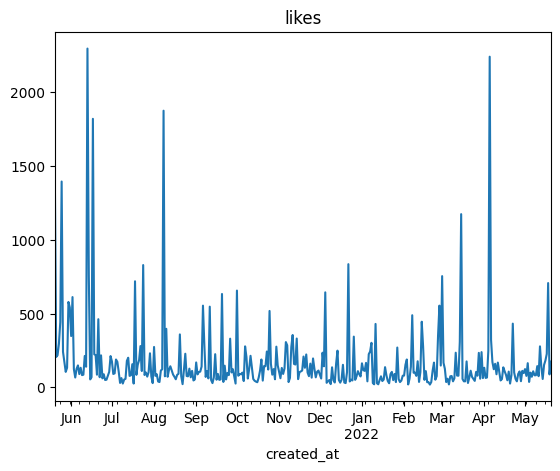

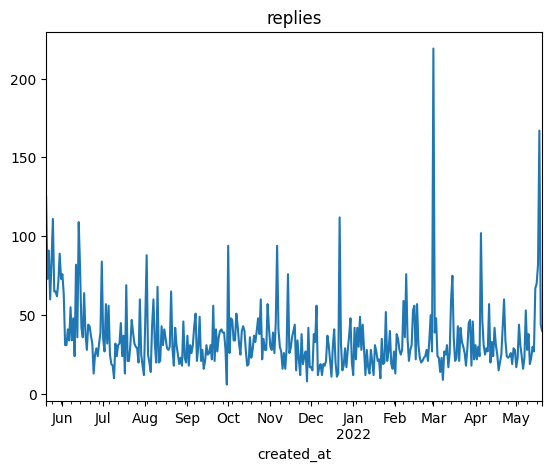

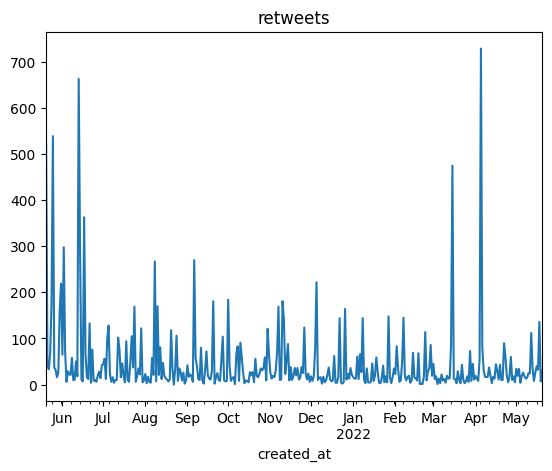

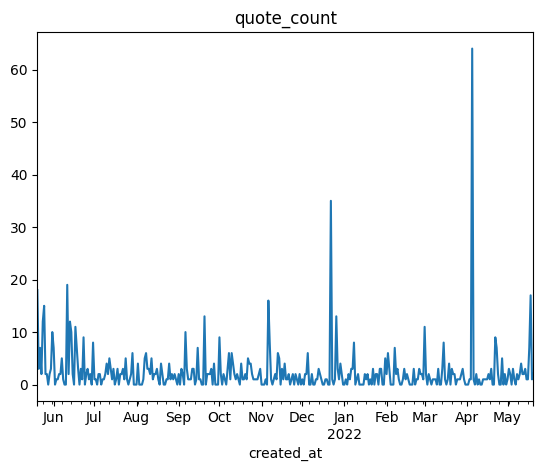

In [6]:
for column in columns:
    data[column].plot()
    plt.title(column)
    plt.show()

From the plots, all 4 series appear to be stationary. To be absolutely certain, we need to conduct some tests on our series. Also note that there are no seasonal patterns in our series, so we may not have to use the SARIMA model (seasonal ARIMA). But for that too, we will need to conduct some tests.

## Testing for stationary series

Here we test whether our series are stationary or not. We will use the Augmented Dickey-Fuller test for this. The null hypothesis for this test is that the time series is not stationary. Hence, if we get our p-value to be less than the `threshold`, we conclude that the series is stationary. If a series is not stationary, we can attempt to make it stationary by differencing. The number of times we need to differentiate our series determines the integrating (I) order of the ARIMA model.

In [7]:
adf_threshold = 5e-2

for column in columns:
    result = adfuller(data[column])
    p_value = result[1]
    if p_value < adf_threshold:
        print(f"Series {column} is stationary with p-value: {p_value}")
    else:
        print(f"Series {column} is not stationary with p-value: {p_value}")

Series likes is stationary with p-value: 5.435908647392098e-12
Series replies is stationary with p-value: 8.736032905174089e-18
Series retweets is stationary with p-value: 1.02918409821964e-13
Series quote_count is stationary with p-value: 0.0


We now have strong statistical evidence that our series are stationary and can be fed into an ARIMA model. Since we do not have to differentiate our series, the integrating order will be 0 for all four series. Hence the ARIMA model will be equivalent to an ARMA model.

Even though our series are stationary, we will look into the case when the series would have been non-stationary. If our series would not have been stationary, we would have to differentiate it ($y_t=y_t-y_{t-1}$). Generally, we achieve stationarity with differencing at most twice.

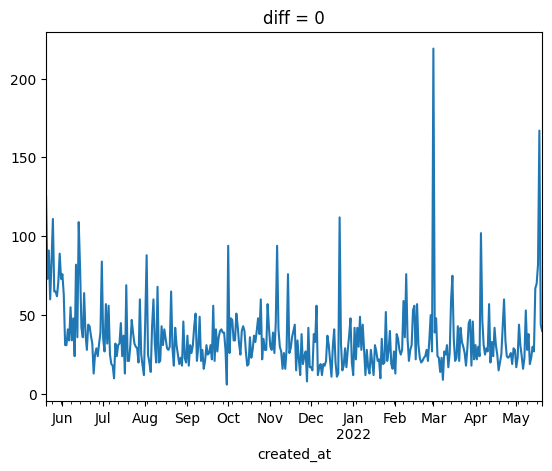

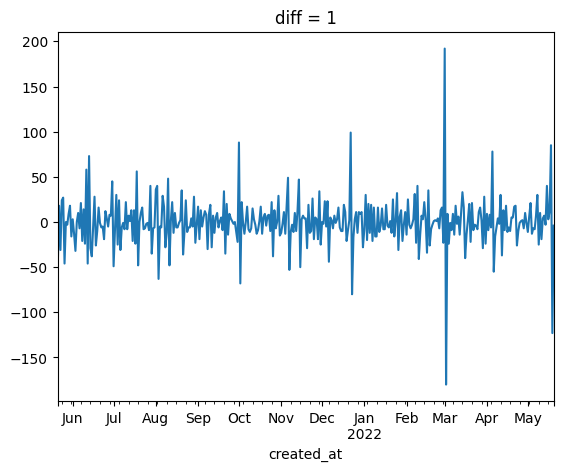

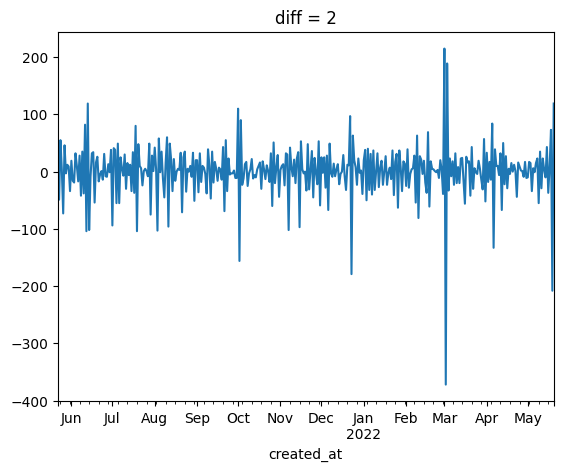

In [8]:
for diff in range(3):
    differenced_series(data["replies"], diff).plot()
    plt.title(f"diff = {diff}")
    plt.show()

## Testing for seasonality and correlation

Now, we test for seasonality and autocorrelation in our series. This is important to predict the necessary orders for our ARIMA model, specifically the order for autoregressive (AR) and moving average (MA) components. We plot the autocorrelation function (ACF) and the partial autocorrelation function (PACF) for this.

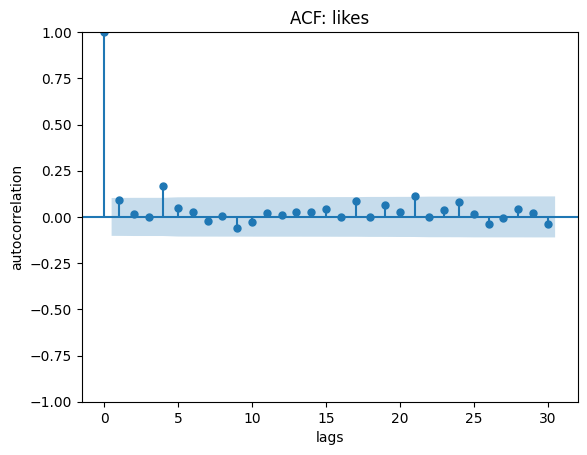

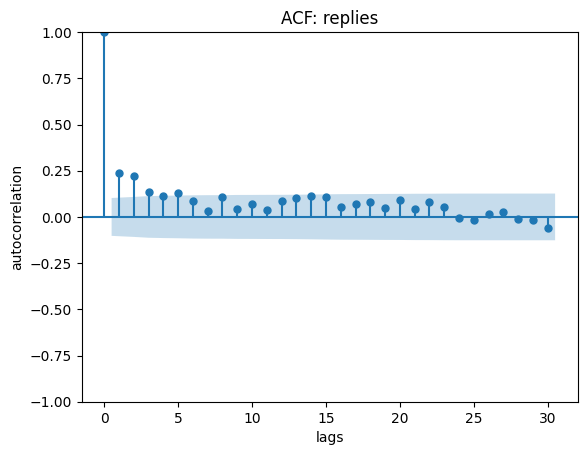

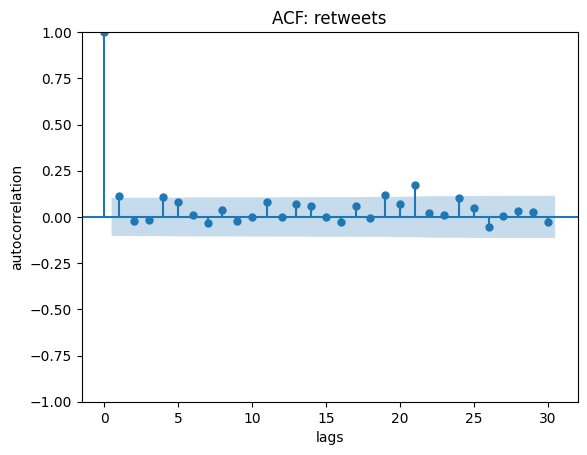

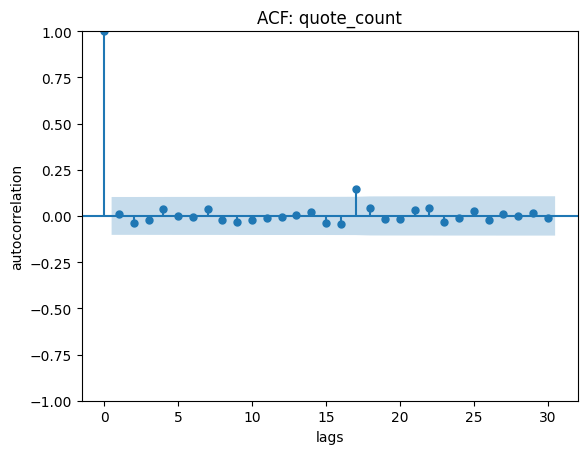

In [9]:
lags = 30
threshold = 5e-2

for column in columns:
    plot_acf((data[column]), lags=lags, alpha=threshold)
    plt.title(f"ACF: {column}")
    plt.xlabel("lags")
    plt.ylabel("autocorrelation")
    plt.show()

The ACF plots help determine the moving average order. A sharp cutoff in the ACF plot after lag $q$ indicates an $\text{MA}(q)$ process. Here, we can see that only the "replies" series has a strong cutoff in its ACF plot, indicating it is the only moving average process. Hence, we will test $q=2$ and $q=3$ models for "replies" series. We can also test for $q=1$ for "retweets" series since it has a small cutoff after lag 1.

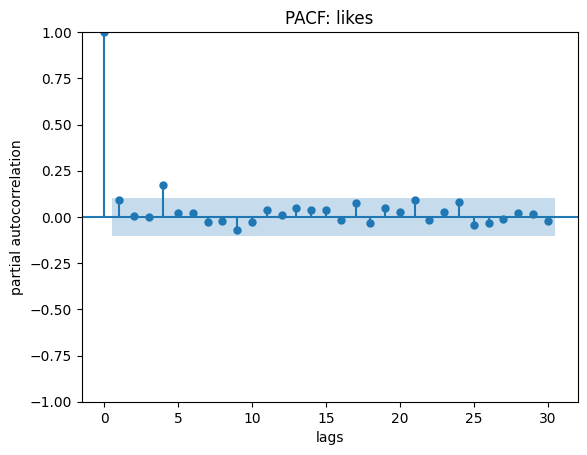

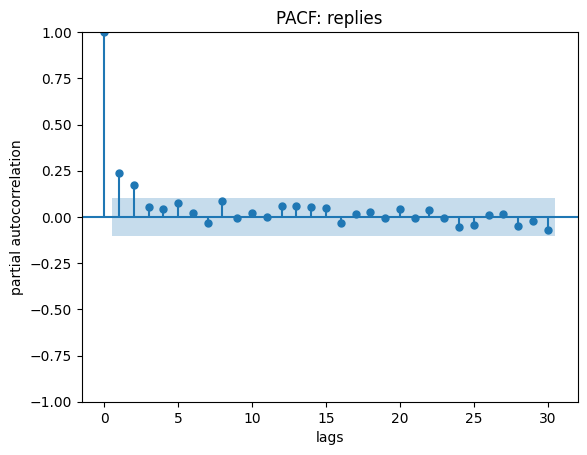

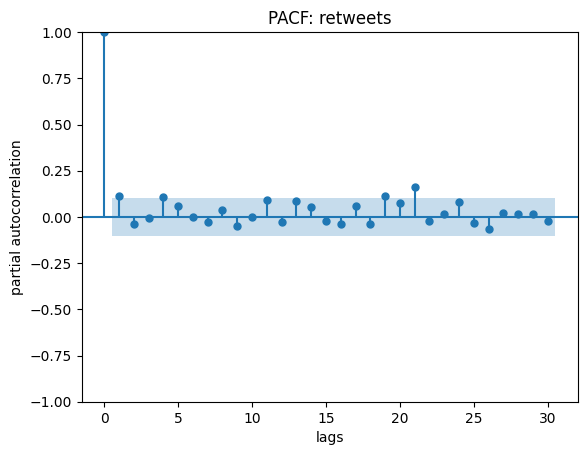

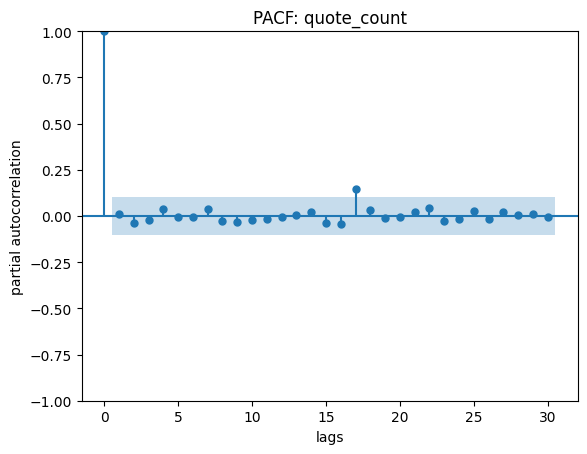

In [10]:
for column in columns:
    plot_pacf((data[column]), lags=lags, alpha=threshold)
    plt.title(f"PACF: {column}")
    plt.xlabel("lags")
    plt.ylabel("partial autocorrelation")
    plt.show()

The PACF plots help determine the autoregressive order since PACF plots show us the direct correlation between the lagged version of a series, ignoring any effects carried on by intermediate lags. We should include the lags with high partial autocorrelation in our autoregressive model by using $\text{AR}(p)$ for lag $p$. Hence, we will try $p=4$ for "likes", $p=2$ for "replies", $p=1$, $p=4$, and $p=21$ for "retweets", and $p=17$ for "quote_count".

## Evaluating models

Now we will compare different possible models for our time series and test them to see how well they perform.

### Fitting the models

Here we hard code the orders we are testing on and fit the corresponsing models. Fitted models are stored in a dictionary `fitted_models` with keys as series name and value as a list containing the different models.

In [11]:
all_orders = [

    # likes series
    [(4, 0, 0)],

    # replies series
    [(2, 0, 2), (2, 0, 3)],

    # retweets series
    [(1, 0, 0), (4, 0, 0), (21, 0, 0)],

    # quote_count series
    [(17, 0, 0)]
]

fitted_models = {}
for column, orders in zip(columns, all_orders):
    fitted_models[column] = []
    for order in orders:
        model = ARIMA(data[column], order=order)
        fitted_models[column].append(model.fit())

### Choosing the best model

Now, we choose the best model with minimum BIC (Bayesian Information Criterion) score. We use BIC instead of AIC (Akaike Information Criterion) since BIC penalizes complex models more than AIC. We prefer less complex models because we have a small dataset and want to avoid overfitting.

In [16]:
best_models = {}
for column, models in fitted_models.items():
    BIC_scores = np.array([model.bic for model in models])
    best_idx = np.argmin(BIC_scores)
    best_models[column] = models[best_idx]

In [17]:
best_models

{'likes': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x321f08fb0>,
 'replies': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x320a5d610>,
 'retweets': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x32028a7e0>,
 'quote_count': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x320257080>}